# Data Processing

First, let's install the necessary packages

In [2]:
from collections import defaultdict
from datetime import datetime
import math
from operator import itemgetter
import os
import random
import re

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, TweetTokenizer

tk = TweetTokenizer()

import numpy as np
import pandas as pd

%matplotlib inline
# !pip install little_mallet_wrapper
import little_mallet_wrapper as lmw


# MALLET

I will be using the MALLET topic model, which is a faster topic model that is suited towards shorter documents, such as those found on social media. Specifically, I will be using a python wrapper for MALLET, called the [little mallet wrapper](https://github.com/maria-antoniak/little-mallet-wrapper) (lmw).

 Here, we set the path to the location of our local MALLET installation. 

In [3]:
path_to_mallet = 'C:/mallet-2.0.8/bin/mallet'  # CHANGE THIS TO YOUR MALLET PATH

# Reddit corpus

This corpus was created by scraping 57 non-quarantined and 51 quarantined subreddits with an upper limit of the top 100 posts and top 50 comments per post for each subreddit. Corpus creation took approximately 11.84 hours.

In [230]:
corpus_info_path = './corpus/test_3/100_50_info.csv'
corpus_comments_path = './corpus/test_3/100_50_comments.csv'

In [231]:
corpus_info_df = pd.read_csv(corpus_info_path)
corpus_comments_df = pd.read_csv(corpus_comments_path)

 The `info.csv` is a table that contains information about each subreddit, such as number of subscribers, creation date, and description.

In [232]:
corpus_info_df.head()

,Unnamed: 0,subreddit_name,subreddit_id,quarantined,subscribers,created_utc,public_description
0,0,Vaccines,t5_2r9k3,0,6109,1.255351e+09,This subreddit is committed to answering quest...
1,1,CovidVaccine,t5_2ls1x1,0,5578,1.587718e+09,NaN
2,2,AntiVaxxers,t5_384mz,0,30318,1.430942e+09,Anything Anti-Vaxx related. \nNOTE: Though the...
3,3,vaxxhappened,t5_3p3pv,0,372160,1.507683e+09,Pro vaccine subreddit shining a light on dimwi...
4,4,antivaccine,t5_2wm9w,0,12269,1.363227e+09,Welcome to /r/AntiVaccine! Slamming Big Pharma...


The `comments.csv` is a table that contains the corpus, where each row is a separate comment, and information about the comment such as the subreddit and post it came from, as well as comment creation date, score, and awards. 

In [233]:
corpus_comments_df.head()

,Unnamed: 0,subreddit_name,quarantined,post_id,comment_id,permalink,author,created_utc,score,awards,stickied,edited,body
0,0,Vaccines,0,t3_k5zbnn,geili74,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,rolacl,1.607023e+09,3,[],False,False,Good for you girl. 💪🏻💪🏻
1,1,Vaccines,0,t3_k5zbnn,gej1b2u,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,NaN,1.607030e+09,2,[],False,False,Congrats friend! Welcome out of the dark ages!
2,2,Vaccines,0,t3_k5zbnn,gej3jkj,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,MBmondongo,1.607031e+09,1,[],False,False,I love this!
3,3,Vaccines,0,t3_k5zbnn,gejh10s,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,NaN,1.607037e+09,1,[],False,False,[removed]
4,4,Vaccines,0,t3_k5zbnn,gek56u9,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,teensforvaxx,1.607052e+09,1,[],False,False,Hey there! Congrats on getting vaccinated! Gav...


As we can see, we have scraped a total of 173,834 comments.

In [234]:
print(len(corpus_comments_df.index))

173834


## Cleaning the corpus

We have two goals
1. Removing non-english, non-utf8, or emoji-based comments that will cause encoding and processing errors with MALLET
2. Checking and removing repeated (possibly by bots), removed, or deleted comments


Let us process each string using little mallet wrapper's `process_string` function, which will transform all text to lowercase, remove stopwords, punctuation, and numbers.

In [235]:
training_data = [lmw.process_string(t) for t in corpus_comments_df['body'].tolist()]

In [184]:
f = open("process_test.txt", "w")
for i, t in enumerate(corpus_comments_df['body'].tolist()):
    try:
        result = lmw.process_string(t)
        f.write(result+"\n")
    except:
        f.write("Error on line: " + str(i) + "\n")


In [9]:
len(training_data)

172583

From previous testing, I have found that the `process_string` function may not always capture comments with non-english characters, so I use a proxy test of printing to a file.

In [236]:
f = open("corpus_encoding_test.txt", "w")
lines_to_remove = []
error_count = 0
empty_count = 0
for index, c in enumerate(training_data):
    try:
        print(c, file=f)
        
        if not c.strip():
            lines_to_remove += [index]
            empty_count += 1

    except:
        lines_to_remove += [index]
        error_count += 1

print("error count:", error_count)
print("empty count:", empty_count)
print("lines to remove:", len(lines_to_remove))

error count: 9
empty count: 1251
lines to remove: 1260


In [237]:
processed_corpus = corpus_comments_df.drop(labels=lines_to_remove, axis=0, inplace=False)
processed_corpus.shape

(172574, 13)

Saving and adding easy access to upload our processed corpus.

In [238]:
processed_corpus.to_csv('./corpus/test_3/processed_100_50_comments.csv', index=False)

In [4]:
processed_corpus = pd.read_csv('./corpus/test_3/processed_100_50_comments.csv')

## Bot detection
Currently there is no standardized service to detect bots from Reddit. Instead, as a proxy measure I will examine all repeated comments and remove them based on qualitative observation

In [240]:
print(len(processed_corpus['body'].unique()))
print(len(processed_corpus)-len(processed_corpus['body'].unique()))

160421
12153


Out of 173,825 of the processed comments, 160,421 comments are unique, and 12,153 are duplicates.

First, let us consider deleted or removed comments. Comments deleted by the user will still be accessible to be scraped, but the body of the comment will be "[removed]" or "[deleted]".

In [241]:
removed = len(processed_corpus[processed_corpus['body'] == "[removed]"])
removed

2257

In [242]:
deleted = len(processed_corpus[processed_corpus['body'] == "[deleted]"])
deleted

5553

In [243]:
removed+deleted

7810

In [244]:
not_rem_del_corpus = processed_corpus[(processed_corpus['body'] != "[deleted]") & (processed_corpus['body'] != "[removed]")]
not_rem_del_corpus.shape

(164764, 13)

In [245]:
assert(len(not_rem_del_corpus) == len(processed_corpus) - (removed + deleted))

We find that a total of 7,810 comments are deleted or removed comments from the original 12,153 comments that were duplicates. What about the remaining comments?

In [246]:
duplicated = not_rem_del_corpus[not_rem_del_corpus.duplicated(['body'], keep=False)]
print(duplicated.shape)

(6426, 13)


In [247]:
duplicates = duplicated.pivot_table(columns=['body'], aggfunc='size').sort_values(ascending=False)
duplicates.to_csv('./corpus/test_3/duplicates_100_50_comments.csv', index=False)
duplicates.head()

body
Thank you!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               139
Thank you for posting to r/CanadaCoronavirus. Please read our [rules](https://www.reddit.com/r/canadacoronavirus/about/rules).\n\nPlease remember that all posts and comments should reflect factual, truth-based discussion. The purpose of this subreddit is to share trustworthy re

In [248]:
duplicated.shape

(6426, 13)

As seen by the 2nd top duplicated comment, some duplicated comments are from bots that rather helpfully identify themselves as bots. Such bots are often used for moderation, where the first comment on any post is automated and reminds users of the subreddit's moderation policies and comment guidelines. 

From a quick search in the duplicated comments I found many instances of the word "bot" or "bots" being used. While many explicitly stated "I am a bot" or "I'm a bot", other references were actual discussions revolving around bots. 

I also tested the word "robot", and found 3 instances, where 1 was actually a bot (stating "I am a robot") while the other two comments (each repeated twice) referenced Bill Gates being a robot and the "robot government".

As I do not want to remove actual comments discussing bots, I will remove all comments that self identify as bots.

In [249]:
possible_bots = duplicated[duplicated['body'].str.contains('\\b(I am|I\'m) a (ro)?bot\\b', regex=True)]
print(possible_bots.shape)

duplicated_bots = possible_bots.pivot_table(columns=['body'], aggfunc='size').sort_values(ascending=False)
duplicated_bots.to_csv('./corpus/test_3/duplicated_bots_100_50_comments.csv', index=False)

print(duplicated_bots.head())

(463, 13)
body
Thank you for posting to r/CanadaCoronavirus. Please read our [rules](https://www.reddit.com/r/canadacoronavirus/about/rules).\n\nPlease remember that all posts and comments should reflect factual, truth-based discussion. The purpose of this subreddit is to share trustworthy resources and ensure Canadians are as informed and educated as possible.\n\nWe will not tolerate racism, sexism, or harassment of any kind. \n\nAny comments or posts made contrary to these values will be subject to review by the Mod team\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/CanadaCoronavirus) if you have any questions or concerns.*                                                                                                                                                                                                            93
\nWelcome to r/CoronavirusGA! We have some basic rules here. Here are

C:\Users\qjuli\AppData\Local\Temp/ipykernel_36340/1540027190.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  possible_bots = duplicated[duplicated['body'].str.contains('\\b(I am|I\'m) a (ro)?bot\\b', regex=True)]


Now let us remove all 463 self-identifying bots from the corpus.

In [250]:
not_rem_del_bot_corpus = not_rem_del_corpus[~not_rem_del_corpus['body'].str.contains('\\b(I am|I\'m) a (ro)?bot\\b', regex=True)]
print(not_rem_del_corpus.shape)
print(not_rem_del_bot_corpus.shape)

C:\Users\qjuli\AppData\Local\Temp/ipykernel_36340/1572140565.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  not_rem_del_bot_corpus = not_rem_del_corpus[~not_rem_del_corpus['body'].str.contains('\\b(I am|I\'m) a (ro)?bot\\b', regex=True)]


(164764, 13)
(164101, 13)


Now let's save our processed corpus where the removed and deleted, as well as self identifying as bots comments have been removed.

In [251]:
not_rem_del_bot_corpus.head()

,Unnamed: 0,subreddit_name,quarantined,post_id,comment_id,permalink,author,created_utc,score,awards,stickied,edited,body
0,0,Vaccines,0,t3_k5zbnn,geili74,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,rolacl,1.607023e+09,3,[],False,False,Good for you girl. 💪🏻💪🏻
1,1,Vaccines,0,t3_k5zbnn,gej1b2u,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,NaN,1.607030e+09,2,[],False,False,Congrats friend! Welcome out of the dark ages!
2,2,Vaccines,0,t3_k5zbnn,gej3jkj,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,MBmondongo,1.607031e+09,1,[],False,False,I love this!
4,4,Vaccines,0,t3_k5zbnn,gek56u9,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,teensforvaxx,1.607052e+09,1,[],False,False,Hey there! Congrats on getting vaccinated! Gav...
5,5,Vaccines,0,t3_k5zbnn,gel63k1,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,someth1ng_au,1.607083e+09,1,[],False,False,I'm glad you lived long enough to get the shots!


Let's take a moment to remove our "Unnamed" column, which was from a previous call to the `to_csv` function without the parameter `index` being set to `False`.

In [252]:
columns = ["Unnamed: 0"]
not_rem_del_bot_corpus.drop(labels=columns, axis = 1, inplace=True)
print(not_rem_del_bot_corpus.head())
print(not_rem_del_bot_corpus.shape)

  subreddit_name  quarantined    post_id comment_id  \
0       Vaccines            0  t3_k5zbnn    geili74   
1       Vaccines            0  t3_k5zbnn    gej1b2u   
2       Vaccines            0  t3_k5zbnn    gej3jkj   
4       Vaccines            0  t3_k5zbnn    gek56u9   
5       Vaccines            0  t3_k5zbnn    gel63k1   

                                           permalink        author  \
0  /r/VACCINES/comments/k5zbnn/raised_antivaxx_an...        rolacl   
1  /r/VACCINES/comments/k5zbnn/raised_antivaxx_an...           NaN   
2  /r/VACCINES/comments/k5zbnn/raised_antivaxx_an...    MBmondongo   
4  /r/VACCINES/comments/k5zbnn/raised_antivaxx_an...  teensforvaxx   
5  /r/VACCINES/comments/k5zbnn/raised_antivaxx_an...  someth1ng_au   

    created_utc  score awards  stickied edited  \
0  1.607023e+09      3     []     False  False   
1  1.607030e+09      2     []     False  False   
2  1.607031e+09      1     []     False  False   
4  1.607052e+09      1     []     False  False  

C:\Users\qjuli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [253]:
not_rem_del_bot_corpus.to_csv('./corpus/test_3/processed_rem_del_bot_100_50_comments.csv', index=False)

In [254]:
corpus_df = pd.read_csv('./corpus/test_3/processed_rem_del_bot_100_50_comments.csv')
print(corpus_df.head())
print(corpus_df.shape)

  subreddit_name  quarantined    post_id comment_id  \
0       Vaccines            0  t3_k5zbnn    geili74   
1       Vaccines            0  t3_k5zbnn    gej1b2u   
2       Vaccines            0  t3_k5zbnn    gej3jkj   
3       Vaccines            0  t3_k5zbnn    gek56u9   
4       Vaccines            0  t3_k5zbnn    gel63k1   

                                           permalink        author  \
0  /r/VACCINES/comments/k5zbnn/raised_antivaxx_an...        rolacl   
1  /r/VACCINES/comments/k5zbnn/raised_antivaxx_an...           NaN   
2  /r/VACCINES/comments/k5zbnn/raised_antivaxx_an...    MBmondongo   
3  /r/VACCINES/comments/k5zbnn/raised_antivaxx_an...  teensforvaxx   
4  /r/VACCINES/comments/k5zbnn/raised_antivaxx_an...  someth1ng_au   

    created_utc  score awards  stickied edited  \
0  1.607023e+09      3     []     False  False   
1  1.607030e+09      2     []     False  False   
2  1.607031e+09      1     []     False  False   
3  1.607052e+09      1     []     False  False  

## Comment Visualizations

In [255]:
corpus_df = pd.read_csv('./corpus/test_3/processed_rem_del_bot_100_50_comments.csv')
quarantined_df = corpus_df[corpus_df["quarantined"] == 1]
print(len(quarantined_df.index))
print(quarantined_df.head())

15523
       subreddit_name  quarantined    post_id comment_id  \
148578      Plandemic            1  t3_mli82e    gtljfxo   
148579      Plandemic            1  t3_mli82e    gtp8mvx   
148580      Plandemic            1  t3_gqdcqz    frs42rc   
148581      Plandemic            1  t3_gqdcqz    frs40du   
148582      Plandemic            1  t3_gqdcqz    frsp9ka   

                                                permalink     author  \
148578  /r/Plandemic/comments/mli82e/ucoronavirusus_co...   vfclists   
148579  /r/Plandemic/comments/mli82e/ucoronavirusus_co...     tarkay   
148580  /r/Plandemic/comments/gqdcqz/the_cdc_confirms_...     tarkay   
148581  /r/Plandemic/comments/gqdcqz/the_cdc_confirms_...     tarkay   
148582  /r/Plandemic/comments/gqdcqz/the_cdc_confirms_...  BohdiZafa   

         created_utc  score awards  stickied edited  \
148578  1.617734e+09      2     []     False  False   
148579  1.617811e+09      2     []     False  False   
148580  1.590424e+09      5     [] 

In [256]:
non_quarantined_df = corpus_df[corpus_df["quarantined"] == 0]
print(len(non_quarantined_df.index))
print(non_quarantined_df.head())

148578
  subreddit_name  quarantined    post_id comment_id  \
0       Vaccines            0  t3_k5zbnn    geili74   
1       Vaccines            0  t3_k5zbnn    gej1b2u   
2       Vaccines            0  t3_k5zbnn    gej3jkj   
3       Vaccines            0  t3_k5zbnn    gek56u9   
4       Vaccines            0  t3_k5zbnn    gel63k1   

                                           permalink        author  \
0  /r/VACCINES/comments/k5zbnn/raised_antivaxx_an...        rolacl   
1  /r/VACCINES/comments/k5zbnn/raised_antivaxx_an...           NaN   
2  /r/VACCINES/comments/k5zbnn/raised_antivaxx_an...    MBmondongo   
3  /r/VACCINES/comments/k5zbnn/raised_antivaxx_an...  teensforvaxx   
4  /r/VACCINES/comments/k5zbnn/raised_antivaxx_an...  someth1ng_au   

    created_utc  score awards  stickied edited  \
0  1.607023e+09      3     []     False  False   
1  1.607030e+09      2     []     False  False   
2  1.607031e+09      1     []     False  False   
3  1.607052e+09      1     []     False  

In [257]:
from reddit_quarantined_scraper_args import non_quarantined_subreddits, quarantined_subreddits

quarantined_subreddits = quarantined_subreddits()
non_quarantined_subreddits = non_quarantined_subreddits()

q_comment_count = []
comment_count = []

for q_s in quarantined_subreddits:
    q_s_df = quarantined_df[quarantined_df["subreddit_name"]==q_s]
    q_comment_count.append(len(q_s_df.index))

for s in non_quarantined_subreddits:
    s_df = non_quarantined_df[non_quarantined_df["subreddit_name"]==s]
    comment_count.append(len(s_df.index))

q_df = pd.DataFrame({'comments': q_comment_count}, index=quarantined_subreddits)
n_q_df = pd.DataFrame({'comments': comment_count}, index=non_quarantined_subreddits)

q_df = q_df.sort_values(by='comments')
n_q_df = n_q_df.sort_values(by='comments')

[[Text(0, 0, ''),
  Text(1, 0, ''),
  Text(2, 0, ''),
  Text(3, 0, ''),
  Text(4, 0, ''),
  Text(5, 0, ''),
  Text(6, 0, ''),
  Text(7, 0, ''),
  Text(8, 0, ''),
  Text(9, 0, ''),
  Text(10, 0, ''),
  Text(11, 0, ''),
  Text(12, 0, ''),
  Text(13, 0, ''),
  Text(14, 0, ''),
  Text(15, 0, ''),
  Text(16, 0, ''),
  Text(17, 0, ''),
  Text(18, 0, ''),
  Text(19, 0, ''),
  Text(20, 0, ''),
  Text(21, 0, ''),
  Text(22, 0, ''),
  Text(23, 0, ''),
  Text(24, 0, ''),
  Text(25, 0, ''),
  Text(26, 0, ''),
  Text(27, 0, ''),
  Text(28, 0, ''),
  Text(29, 0, ''),
  Text(30, 0, ''),
  Text(31, 0, ''),
  Text(32, 0, ''),
  Text(33, 0, ''),
  Text(34, 0, ''),
  Text(35, 0, ''),
  Text(36, 0, ''),
  Text(37, 0, ''),
  Text(38, 0, ''),
  Text(39, 0, ''),
  Text(40, 0, ''),
  Text(41, 0, ''),
  Text(42, 0, ''),
  Text(43, 0, ''),
  Text(44, 0, ''),
  Text(45, 0, ''),
  Text(46, 0, ''),
  Text(47, 0, ''),
  Text(48, 0, ''),
  Text(49, 0, ''),
  Text(50, 0, '')]]

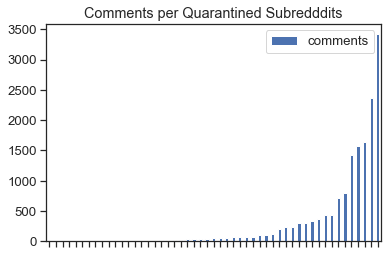

In [258]:
ax = q_df.plot.bar(title="Comments per Quarantined Subredddits", rot=0)
ax.set(xticklabels=[])

[[Text(0, 0, ''),
  Text(1, 0, ''),
  Text(2, 0, ''),
  Text(3, 0, ''),
  Text(4, 0, ''),
  Text(5, 0, ''),
  Text(6, 0, ''),
  Text(7, 0, ''),
  Text(8, 0, ''),
  Text(9, 0, ''),
  Text(10, 0, ''),
  Text(11, 0, ''),
  Text(12, 0, ''),
  Text(13, 0, ''),
  Text(14, 0, ''),
  Text(15, 0, ''),
  Text(16, 0, ''),
  Text(17, 0, ''),
  Text(18, 0, ''),
  Text(19, 0, ''),
  Text(20, 0, ''),
  Text(21, 0, ''),
  Text(22, 0, ''),
  Text(23, 0, ''),
  Text(24, 0, ''),
  Text(25, 0, ''),
  Text(26, 0, ''),
  Text(27, 0, ''),
  Text(28, 0, ''),
  Text(29, 0, ''),
  Text(30, 0, ''),
  Text(31, 0, ''),
  Text(32, 0, ''),
  Text(33, 0, ''),
  Text(34, 0, ''),
  Text(35, 0, ''),
  Text(36, 0, ''),
  Text(37, 0, ''),
  Text(38, 0, ''),
  Text(39, 0, ''),
  Text(40, 0, ''),
  Text(41, 0, ''),
  Text(42, 0, ''),
  Text(43, 0, ''),
  Text(44, 0, ''),
  Text(45, 0, ''),
  Text(46, 0, ''),
  Text(47, 0, ''),
  Text(48, 0, ''),
  Text(49, 0, ''),
  Text(50, 0, ''),
  Text(51, 0, ''),
  Text(52, 0, ''),
  T

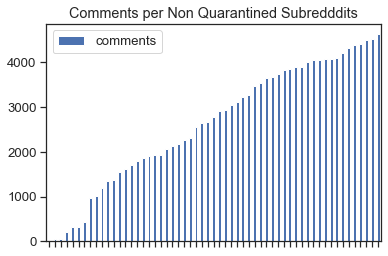

In [259]:
ax = n_q_df.plot.bar(title="Comments per Non Quarantined Subredddits", rot=0)
ax.set(xticklabels=[])

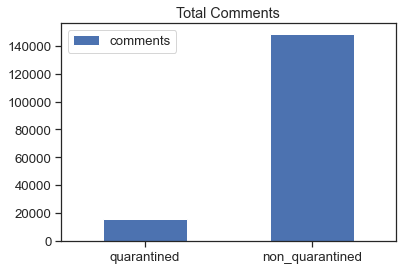

In [260]:
# now a bar chart of them combined
index = ['quarantined', 'non_quarantined']
total_comments = [len(quarantined_df.index), len(non_quarantined_df.index)]
combined_df = pd.DataFrame({'comments': total_comments}, index=index)
ax = combined_df.plot.bar(title="Total Comments", rot=0)

## Tokenizing and Counting Tokens

In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, TweetTokenizer

tk = TweetTokenizer()

In [262]:
corpus_df['tokens'] = None
corpus_df['num_tokens'] = 0
corpus_df

,subreddit_name,quarantined,post_id,comment_id,permalink,author,created_utc,score,awards,stickied,edited,body,tokens,num_tokens
0,Vaccines,0,t3_k5zbnn,geili74,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,rolacl,1.607023e+09,3,[],False,False,Good for you girl. 💪🏻💪🏻,None,0
1,Vaccines,0,t3_k5zbnn,gej1b2u,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,NaN,1.607030e+09,2,[],False,False,Congrats friend! Welcome out of the dark ages!,None,0
2,Vaccines,0,t3_k5zbnn,gej3jkj,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,MBmondongo,1.607031e+09,1,[],False,False,I love this!,None,0
3,Vaccines,0,t3_k5zbnn,gek56u9,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,teensforvaxx,1.607052e+09,1,[],False,False,Hey there! Congrats on getting vaccinated! Gav...,None,0
4,Vaccines,0,t3_k5zbnn,gel63k1,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,someth1ng_au,1.607083e+09,1,[],False,False,I'm glad you lived long enough to get the shots!,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164096,VaccineHomicide,1,t3_p06hgg,h84nnqw,/r/VaccineHomicide/comments/p06hgg/get_the_sho...,polymath22,1.628392e+09,5,[],False,False,/r/VaccineCultVictims,None,0
164097,AntiVaccineMemes,1,t3_mzvoak,gwstopg,/r/AntiVaccineMemes/comments/mzvoak/anti_vaxxe...,LegoJack,1.620060e+09,1,[],False,False,lol.\n\n Submissions are restricted on this co...,None,0
164098,AntiVaccineMemes,1,t3_mzvoak,gx58ta0,/r/AntiVaccineMemes/comments/mzvoak/anti_vaxxe...,balfringRetro,1.620306e+09,1,[],False,False,"Look mom, I'm on TV !",None,0
164099,AntiVaccineMemes,1,t3_mzvoak,gwsttsc,/r/AntiVaccineMemes/comments/mzvoak/anti_vaxxe...,polymath22,1.620060e+09,2,[],False,False,try it now.\n\nbut be careful what you post,None,0


Let us first tokenize using the Twitter tokenizer.

In [263]:
for index, row in corpus_df.iterrows():
    comment_txt = row['body']
    tokens = tk.tokenize(comment_txt)
    corpus_df.iat[index, 12] = tokens
    corpus_df.iat[index, 13]  = len(tokens)

Let's save this tokenized corpus.

In [ ]:
corpus_df.to_csv('./corpus/test_3/processed_rem_del_bot_100_50_comments.csv', index=False)

In [4]:
corpus_df = pd.read_csv('./corpus/test_3/processed_rem_del_bot_100_50_comments.csv')

In [5]:
corpus_df.head()

,subreddit_name,quarantined,post_id,comment_id,permalink,author,created_utc,score,awards,stickied,edited,body,tokens,num_tokens
0,Vaccines,0,t3_k5zbnn,geili74,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,rolacl,1.607023e+09,3,[],False,False,Good for you girl. 💪🏻💪🏻,"['Good', 'for', 'you', 'girl', '.', '💪🏻', '💪🏻']",7
1,Vaccines,0,t3_k5zbnn,gej1b2u,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,NaN,1.607030e+09,2,[],False,False,Congrats friend! Welcome out of the dark ages!,"['Congrats', 'friend', '!', 'Welcome', 'out', ...",10
2,Vaccines,0,t3_k5zbnn,gej3jkj,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,MBmondongo,1.607031e+09,1,[],False,False,I love this!,"['I', 'love', 'this', '!']",4
3,Vaccines,0,t3_k5zbnn,gek56u9,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,teensforvaxx,1.607052e+09,1,[],False,False,Hey there! Congrats on getting vaccinated! Gav...,"['Hey', 'there', '!', 'Congrats', 'on', 'getti...",16
4,Vaccines,0,t3_k5zbnn,gel63k1,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,someth1ng_au,1.607083e+09,1,[],False,False,I'm glad you lived long enough to get the shots!,"[""I'm"", 'glad', 'you', 'lived', 'long', 'enoug...",11


In [6]:
corpus_df.shape

(164101, 14)

Let us also get the token count for the processed data using `lmw.process_string`. Notice earlier that this funciton does remove emojis and other non-utf8 encoded text, and we wish to see if this processing has any major impact on the corpus.

In [7]:
corpus_df['lmw_text'] = None
corpus_df['lmw_tokens'] = None
corpus_df['lmw_num_tokens'] = 0

In [8]:
corpus_df.head()

,subreddit_name,quarantined,post_id,comment_id,permalink,author,created_utc,score,awards,stickied,edited,body,tokens,num_tokens,lmw_text,lmw_tokens,lmw_num_tokens
0,Vaccines,0,t3_k5zbnn,geili74,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,rolacl,1.607023e+09,3,[],False,False,Good for you girl. 💪🏻💪🏻,"['Good', 'for', 'you', 'girl', '.', '💪🏻', '💪🏻']",7,None,None,0
1,Vaccines,0,t3_k5zbnn,gej1b2u,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,NaN,1.607030e+09,2,[],False,False,Congrats friend! Welcome out of the dark ages!,"['Congrats', 'friend', '!', 'Welcome', 'out', ...",10,None,None,0
2,Vaccines,0,t3_k5zbnn,gej3jkj,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,MBmondongo,1.607031e+09,1,[],False,False,I love this!,"['I', 'love', 'this', '!']",4,None,None,0
3,Vaccines,0,t3_k5zbnn,gek56u9,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,teensforvaxx,1.607052e+09,1,[],False,False,Hey there! Congrats on getting vaccinated! Gav...,"['Hey', 'there', '!', 'Congrats', 'on', 'getti...",16,None,None,0
4,Vaccines,0,t3_k5zbnn,gel63k1,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,someth1ng_au,1.607083e+09,1,[],False,False,I'm glad you lived long enough to get the shots!,"[""I'm"", 'glad', 'you', 'lived', 'long', 'enoug...",11,None,None,0


In [9]:
for index, row in corpus_df.iterrows():
    comment_txt = lmw.process_string(row['body'])
    tokens = tk.tokenize(comment_txt)
    corpus_df.iat[index, 14] = comment_txt
    corpus_df.iat[index, 15]  = tokens
    corpus_df.iat[index, 16]  = len(tokens)

In [10]:
corpus_df.head()

,subreddit_name,quarantined,post_id,comment_id,permalink,author,created_utc,score,awards,stickied,edited,body,tokens,num_tokens,lmw_text,lmw_tokens,lmw_num_tokens
0,Vaccines,0,t3_k5zbnn,geili74,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,rolacl,1.607023e+09,3,[],False,False,Good for you girl. 💪🏻💪🏻,"['Good', 'for', 'you', 'girl', '.', '💪🏻', '💪🏻']",7,good girl,"[good, girl]",2
1,Vaccines,0,t3_k5zbnn,gej1b2u,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,NaN,1.607030e+09,2,[],False,False,Congrats friend! Welcome out of the dark ages!,"['Congrats', 'friend', '!', 'Welcome', 'out', ...",10,congrats friend welcome dark ages,"[congrats, friend, welcome, dark, ages]",5
2,Vaccines,0,t3_k5zbnn,gej3jkj,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,MBmondongo,1.607031e+09,1,[],False,False,I love this!,"['I', 'love', 'this', '!']",4,love,[love],1
3,Vaccines,0,t3_k5zbnn,gek56u9,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,teensforvaxx,1.607052e+09,1,[],False,False,Hey there! Congrats on getting vaccinated! Gav...,"['Hey', 'there', '!', 'Congrats', 'on', 'getti...",16,hey congrats getting vaccinated gave award,"[hey, congrats, getting, vaccinated, gave, award]",6
4,Vaccines,0,t3_k5zbnn,gel63k1,/r/VACCINES/comments/k5zbnn/raised_antivaxx_an...,someth1ng_au,1.607083e+09,1,[],False,False,I'm glad you lived long enough to get the shots!,"[""I'm"", 'glad', 'you', 'lived', 'long', 'enoug...",11,glad lived long enough get shots,"[glad, lived, long, enough, get, shots]",6


This will be the final corpus we will use to create our training data for the topic model.

In [11]:
corpus_df.to_csv('./corpus/test_3/tokenized_processed_rem_del_bot_100_50_comments.csv', index=False)

In [13]:
corpus_df = pd.read_csv('./corpus/test_3/tokenized_processed_rem_del_bot_100_50_comments.csv')

In [15]:
corpus_df.shape

(164101, 17)

## Token Visualizations

quarantined_tokenized_df shape: (15523, 17)
non_quarantined_tokenized_df shape: (148578, 17)
The following is in the form of [quarantined, non_quarantined]
total comments: [15523, 148578]
token count: [627295, 6946609]
avg token per comment: [40.410680925078914, 46.753954152027895]
lmw processed token count: [311459, 3212379]
lmw processed avg token per comment [20.064356116730014, 21.620825425029278]
[15523, 148578]
[627295, 6946609]
[40.410680925078914, 46.753954152027895]


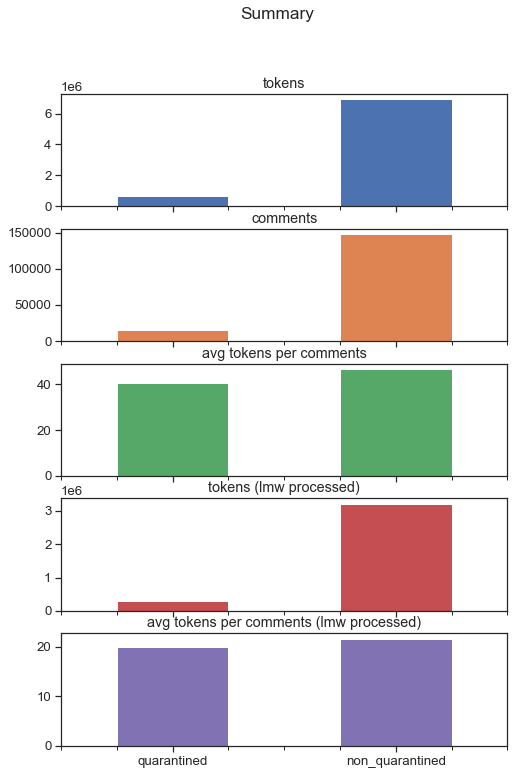

In [16]:
index = ['quarantined', 'non_quarantined']
quarantined_tokenized_df = corpus_df[corpus_df['quarantined'] == 1]
non_quarantined_tokenized_df = corpus_df[corpus_df['quarantined'] == 0]

print("quarantined_tokenized_df shape:", quarantined_tokenized_df.shape)
print("non_quarantined_tokenized_df shape:", non_quarantined_tokenized_df.shape)
print("The following is in the form of [quarantined, non_quarantined]")

total_comments = [len(quarantined_tokenized_df.index), len(non_quarantined_tokenized_df.index)]
print("total comments:", total_comments)

token_count = [quarantined_tokenized_df['num_tokens'].sum(), non_quarantined_tokenized_df['num_tokens'].sum()]
print("token count:", token_count)

avg_token_per_comment = [tokens/comments for tokens, comments in zip(token_count, total_comments)]
print("avg token per comment:", avg_token_per_comment)

lmw_token_count = [quarantined_tokenized_df['lmw_num_tokens'].sum(), non_quarantined_tokenized_df['lmw_num_tokens'].sum()]
print("lmw processed token count:", lmw_token_count)

lmw_avg_token_per_comment = [tokens/comments for tokens, comments in zip(lmw_token_count, total_comments)]
print("lmw processed avg token per comment", lmw_avg_token_per_comment)

summary_df = pd.DataFrame(
    {'tokens': token_count, 
     'comments': total_comments, 
     'avg tokens per comments': avg_token_per_comment,
     'tokens (lmw processed)': lmw_token_count,
     'avg tokens per comments (lmw processed)': lmw_avg_token_per_comment
    }, 
      index = index)

ax = summary_df.plot.bar(title="Summary", rot=0, subplots=True, figsize=(8,12), legend=False)

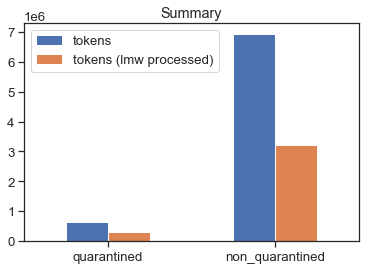

In [26]:
summary_df = pd.DataFrame(
    {'tokens': token_count, 
     'tokens (lmw processed)': lmw_token_count,
    }, 
      index = index)

ax = summary_df.plot.bar(title="Summary", rot=0, figsize=(6,4))

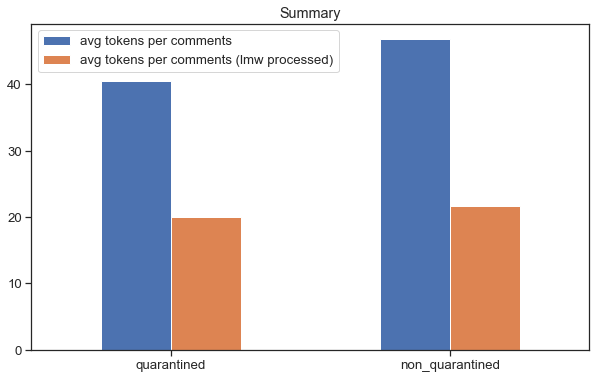

In [32]:
summary_df = pd.DataFrame(
    {
     'avg tokens per comments': avg_token_per_comment,
     'avg tokens per comments (lmw processed)': lmw_avg_token_per_comment
    }, 
      index = index)

ax = summary_df.plot.bar(title="Summary", rot=0, figsize=(10,6))

# Create our Topic Model Training Data

Now let's create our document data frame for our topic model. As there were 15,523 quarantined comments vs 148,578 non-quarantined comments, we will randomly sample 15,500 comments from each group. Using the pandas `groupby` function, we will make sure to select a representative sample of each subreddit within the quarantined and non-quarantined groups.

In [3]:
corpus_df = pd.read_csv('./corpus/test_3/tokenized_processed_rem_del_bot_100_50_comments.csv')

In [4]:
quarantined_df = corpus_df[corpus_df["quarantined"] == 1]
non_quarantined_df = corpus_df[corpus_df["quarantined"] == 0]

In [7]:
quarantined_subs = quarantined_df['subreddit_name'].unique()
print(quarantined_subs)
print(len(quarantined_subs))

['Plandemic' 'vaccinelonghaulers' 'LockdownSkepticismCAN' 'vacci_nation'
 'covidisafraud' 'CovidVaccineInjury' 'CovidVaccinatedUncut'
 'covid19origin' 'EndTheLockdowns' 'Wuhan_Flu' 'trueantivaccination'
 'NoLockdownsNoMasks' 'VaccineData' 'VaccineBDS' 'VaccineRevolt'
 'VakzinationMachtFrei' 'VaccineRape' 'VaccineRefusal' 'VaccineProtest'
 'VaccineCensorship' 'VaccineViolence' 'SpikeProtein' 'VaccinerEVOLution'
 'VaccinePeriod' 'HearThisWell' 'ProblemSolvingMatrix'
 'VaccineMyocarditis' 'VaccineEnvy' 'VaccineCoercion' 'VaccineUniversity'
 'VaccineReaction' 'VaccineNarrative' 'VaccineCultVictims' 'DebateVaccine'
 'VaccineGasLight' 'VaccineHomicide' 'AntiVaccineMemes']
37


In [8]:
non_quarantined_subs = non_quarantined_df['subreddit_name'].unique()
print(non_quarantined_subs)
print(len(non_quarantined_subs))

['Vaccines' 'CovidVaccine' 'AntiVaxxers' 'vaxxhappened' 'antivaccine'
 'conspiracy' 'conspiracytheories' 'conspiracy_commons' 'COVID19'
 'Coronavirus' 'COVID19positive' 'worldnews' 'CoronavirusWI'
 'COVID19_support' 'CoronavirusCanada' 'CanadaCoronavirus'
 'LockdownSkepticism' 'CoronavirusUK' 'CoronavirusDownunder'
 'CoronavirusUS' 'CoronavirusCirclejerk' 'covidlonghaulers'
 'FloridaCoronavirus' 'CoronavirusMichigan' 'CoronavirusGA'
 'CoronavirusMa' 'CoronaVirusTX' 'DebateVaccines' 'CoronavirusCA'
 'CoronavirusWA' 'CoronavirusAZ' 'Coronaviruslouisiana'
 'CoronavirusOregon' 'CoronavirusOklahoma' 'CoronavirusUT'
 'CoronavirusColorado' 'coronavirusnewmexico' 'CovidVaccinated'
 'CovIdiots' 'nycCoronavirus' 'LockdownCriticalLeft' 'modernavaccine'
 'CoronavirusIllinois' 'CoronaBumpers' 'TakeTheJab' 'antivax'
 'CoronavirusMemes' 'CoronavirusFOS' 'CoronavirusNewYork' 'nCoV'
 'CoronaVirus_2019_nCoV' 'CoronavirusRecession' 'CoronavirusAustralia'
 'cvnews' 'Pandemic']
55


In [ ]:

random_quarantined_df = quarantined_df.sample(random_state = 1, n=15500)
random_non_quarantined_df = non_quarantined_df.sample(random_state=1, n=15500)

In [34]:
random_quarantined_df.to_csv('corpus/sample/test_3/random_3_quarantined_100_50_info.csv', index=False)
random_non_quarantined_df.to_csv('corpus/sample/test_3/random_3_non_quarantined_100_50_info.csv', index=False)

In [35]:
random_quarantined_df = pd.read_csv('corpus/sample/test_3/random_3_quarantined_100_50_info.csv')
random_non_quarantined_df = pd.read_csv('corpus/sample/test_3/random_3_non_quarantined_100_50_info.csv')

In [37]:
print(random_quarantined_df.shape)

(15500, 17)


In [39]:
print(random_non_quarantined_df.shape)

(15500, 17)


In [40]:
frames = [random_quarantined_df, random_non_quarantined_df]
reddit_df = pd.concat(frames)
reddit_df.to_csv('corpus/sample/test_3/random_3_100_50_comments.csv', index=False)

In [48]:
reddit_df = pd.read_csv('corpus/sample/test_3/random_3_100_50_comments.csv', encoding='utf8')

In [49]:
reddit_df.shape

(31000, 17)

In [50]:
reddit_df.head()

,subreddit_name,quarantined,post_id,comment_id,permalink,author,created_utc,score,awards,stickied,edited,body,tokens,num_tokens,lmw_text,lmw_tokens,lmw_num_tokens
0,vaccinelonghaulers,1,t3_p16c7f,h8jhiq0,/r/vaccinelonghaulers/comments/p16c7f/vaccine_...,aprilflowers23,1.628694e+09,2,[],False,False,I needed that so badly last summer. My adrenal...,"['I', 'needed', 'that', 'so', 'badly', 'last',...",96,needed badly last summer adrenaline situation ...,"['needed', 'badly', 'last', 'summer', 'adrenal...",43
1,Wuhan_Flu,1,t3_fdy5z4,fjkp4ap,/r/Wuhan_Flu/comments/fdy5z4/it_do_be_like_tha...,NaN,1.583431e+09,25,[],False,False,They wanna travel and see the world before the...,"['They', 'wanna', 'travel', 'and', 'see', 'the...",17,wanna travel see world die nothing wrong right,"['wanna', 'travel', 'see', 'world', 'die', 'no...",8
2,CovidVaccinatedUncut,1,t3_ouraju,h748daq,/r/CovidVaccinatedUncut/comments/ouraju/vaccin...,volcanicpale,1.627672e+09,16,[],False,False,They’re unable to take a side after they’ve sh...,"['They', '’', 're', 'unable', 'to', 'take', 'a...",23,unable take side shoved pro vaccine propaganda...,"['unable', 'take', 'side', 'shoved', 'pro', 'v...",11
3,VaccinePeriod,1,t3_nun6eb,h0ygg0e,/r/VaccinePeriod/comments/nun6eb/part_of_an_in...,Terminal-Psychosis,1.623101e+09,3,[],False,False,She explains it very well. \n\nAt first the dr...,"['She', 'explains', 'it', 'very', 'well', '.',...",122,explains well first drug companies claimed cel...,"['explains', 'well', 'first', 'drug', 'compani...",63
4,LockdownSkepticismCAN,1,t3_oq8pls,h6bx0cd,/r/LockdownSkepticismCAN/comments/oq8pls/anyon...,Wylde_Won,1.627099e+09,10,[],False,False,I agree with you on all those talking points. ...,"['I', 'agree', 'with', 'you', 'on', 'all', 'th...",44,agree talking points first foremost medical in...,"['agree', 'talking', 'points', 'first', 'forem...",21


# Visualize our Topic Model Training Data

random_quarantined_tokenized_df shape: (15500, 17)
random_non_quarantined_tokenized_df shape: (15500, 17)
The following is in the form of [quarantined, non_quarantined]
total comments: [15500, 15500]
token count: [626779, 720798]
average token per coment: [40.43735483870968, 46.50309677419355]
lmw processed token count: [311181, 330279]
lmw processed avg token per comment [20.076193548387096, 21.30832258064516]


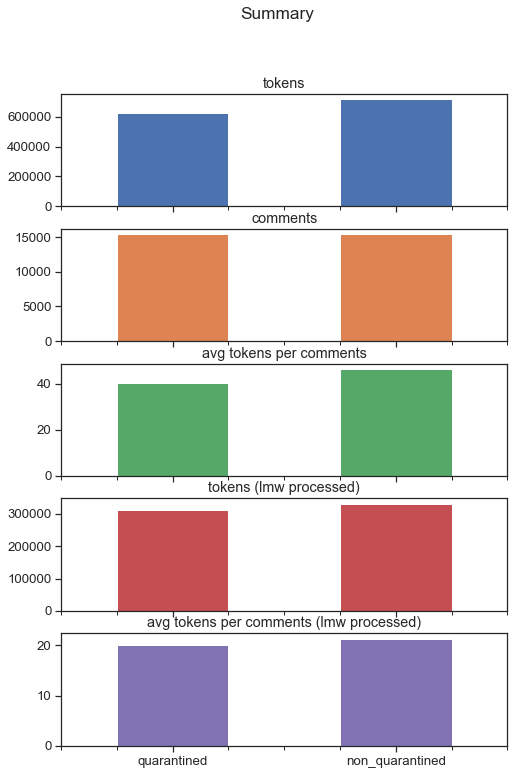

In [51]:
index = ['quarantined', 'non_quarantined']
random_quarantined_tokenized_df = reddit_df[reddit_df['quarantined'] == 1]
random_non_quarantined_tokenized_df = reddit_df[reddit_df['quarantined'] == 0]

print("random_quarantined_tokenized_df shape:", random_quarantined_tokenized_df.shape)
print("random_non_quarantined_tokenized_df shape:", random_non_quarantined_tokenized_df.shape)
print("The following is in the form of [quarantined, non_quarantined]")

random_total_comments = [len(random_quarantined_tokenized_df.index), len(random_non_quarantined_tokenized_df.index)]
print("total comments:", random_total_comments)

random_token_count = [random_quarantined_tokenized_df['num_tokens'].sum(), random_non_quarantined_tokenized_df['num_tokens'].sum()]
print("token count:", random_token_count)

random_avg_token_per_comment = [tokens/comments for tokens, comments in zip(random_token_count, random_total_comments)]
print("average token per coment:", random_avg_token_per_comment)

random_lmw_token_count = [random_quarantined_tokenized_df['lmw_num_tokens'].sum(), random_non_quarantined_tokenized_df['lmw_num_tokens'].sum()]
print("lmw processed token count:", random_lmw_token_count)

random_lmw_avg_token_per_comment = [tokens/comments for tokens, comments in zip(random_lmw_token_count, random_total_comments)]
print("lmw processed avg token per comment", random_lmw_avg_token_per_comment)

summary_df = pd.DataFrame(
    {'tokens': random_token_count, 
     'comments': random_total_comments, 
     'avg tokens per comments': random_avg_token_per_comment,
     'tokens (lmw processed)': random_lmw_token_count,
     'avg tokens per comments (lmw processed)': random_lmw_avg_token_per_comment
    }, 
      index = index)

ax = summary_df.plot.bar(title="Summary", rot=0, subplots=True, figsize=(8,12), legend=False)


## Topic Models

A topic model finds topics, or sets of correlated words, based on a provided collection of documents (or texts) from a set of authors. I will be using an LDA implementation called Mallet, which specializes in smaller documents and treats each document as a "bag of words", where order does not matter. In this case, our authors will be subreddits, and the documents will be all the comments 

In [ ]:
reddit_df = pd.read_csv('corpus/sample/random_3_100_50_comments.csv', encoding='utf8')

In [174]:
reddit_df = reddit_df.rename(columns={'subreddit_name': 'Author', 'comment_id': 'Title'})

In [175]:
reddit_df.to_csv('corpus/sample/random_3_100_50_comments_renamed.csv', index=False)

In [176]:
reddit_df = pd.read_csv('corpus/sample/random_3_100_50_comments_renamed.csv')

In [177]:
reddit_df.shape

(31000, 14)

Note: lmc.process_string automatically removes stop words

In [178]:
training_data = [lmw.process_string(t) for t in reddit_df['body'].tolist()]
training_data = [d for d in training_data if d.strip()]

len(training_data)

30705

In [ ]:
training_data[:10]

['story arnold talking based many truths concentrated effort underway bury truth reddit delete video ccp controlled subs /coronavirus communist chinese government reddit NUMnd largest investor ccp investment paying apparently also bat soup ass',
 'wait vaccinated people likely carry virus look suddenly pro vaccine passport gotta keep mutant freaks away healthy people',
 'said got sick march videos standing running around wedding around may really think someone going complications claiming would energy time full blown wedding walk normally let even talk usb cable taped arm like medical cable',
 'tried making account didn work reason',
 'muscle spasms pressure chest like middle sometimes feel heart racing sure first dose pfizer got might anxiety anyways debating get second dose pass extremely scared since developed high taking cough medication spiked NUM two years ago hospitalized think developed ptsd along anxiety probably hypochondriac haven taken kind medications within year afraid si

In [ ]:
authors = reddit_df['Author'].tolist()
print(reddit_df['Author'].describe())

count         32000
unique           92
top       Wuhan_Flu
freq           3640
Name: Author, dtype: object


In [ ]:
lmw.print_dataset_stats(training_data)

Number of Documents: 31721
Mean Number of Words per Document: 18.9
Vocabulary Size: 36134
